In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np

import cv2
from cv2 import dilate
from cv2 import adaptiveThreshold

from os import listdir
from os.path import isfile, join

from skimage.morphology import *
from skimage import io

In [19]:
def cv_remove_small_objects(im, min_size):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(im, connectivity=8)
    sizes = stats[1:, -1]; 
    nb_components = nb_components - 1

    res = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            res[output == i + 1] = 1
            
    return res

def binarize(im):
    binary_local = im=cv2.adaptiveThreshold(
        src=np.array(cv2.medianBlur(im, 5), dtype=np.uint8), 
        maxValue=255, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=99, 
        C=20)
    
    cleaned = cv_remove_small_objects(binary_local, 200)
    
    strel = cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))    
    cleaned = cv2.dilate(np.array(cleaned, dtype=np.uint8), strel)
    
    return cleaned

def ImageToFeatures(img):
    data = []
    labels = []
    for i, row in enumerate(img):
        for j, val in enumerate(row):
            if val:
                data.append([j, i])
                labels.append(val)    
    return np.array(data), np.array(labels)

def FeaturesToImage(fts, width, height, correction=False):
    minx = min(fts[:, 0])
    miny = min(fts[:, 1])

    maxx = max(fts[:, 0])
    maxy = max(fts[:, 1])
    
    image = np.zeros((width, height))
    
    if correction:
        ft_width = maxx-minx
        ft_height = maxy-miny
        if ft_width > width or ft_height > height:
            return np.zeros((width, height))
        indent_width = int((width-ft_width)/2)
        indent_height = int((height-ft_height)/2)
        for x, y in fts:
            image[y-miny+indent_height, x-minx+indent_width] = 1
    else:
        for x, y in fts:
            image[y, x] = 1
            
    return image

def n_clusters(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)

def get_tracings_from_binarized_image(image, notch_size=700):
    pixels, labels = ImageToFeatures(label(image))
    
    n_clt = n_clusters(labels)
    
    clusters = [np.where(labels==i)[0] for i in range(1, n_clt + 1)]
    
    notches=[]
    for cluster in clusters:
        notches.append([pixels[ix] for ix in cluster])
    notches = np.array(notches)
    
    data=list(map(lambda x: FeaturesToImage(np.array(x), width=notch_size, height=notch_size, correction=True), notches))
    data_src=list(map(lambda x: FeaturesToImage(np.array(x), width=image.shape[0], height=image.shape[1]), notches))
    
    data_prep = []
    for dt in data:
        if dt is not None:
            data_prep.append(dt.reshape(notch_size**2))
        else:
            data_prep.append(np.zeros(notch_size**2))
            
    return (data, data_src, data_prep)

In [20]:
path='d:\\photo1\\'
impaths = [f for f in listdir(path) if isfile(join(path, f))]

In [ ]:
data = []
data_src = []
data_prep = []
for impath in impaths:
    image = cv2.imread(path+impath, cv2.IMREAD_GRAYSCALE)
    bimage = binarize(image)
    d, d_src, d_prep = get_tracings_from_binarized_image(bimage)
    ar

In [34]:
a=[1,2,3]
b=[4,5,6]
a+b

[1, 2, 3, 4, 5, 6]

In [27]:
bimage = binarize(image)

In [29]:
data, data_src, data_prep = get_tracings_from_binarized_image(bimage)

D:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


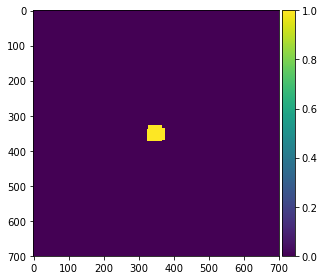

In [33]:
io.imshow(data[2])
plt.show()

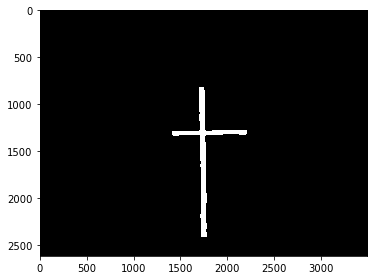

In [32]:
io.imshow(data_src[1])
plt.show()